## 1. Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import re

sns.set(rc={'figure.figsize':(15, 10)})
pd.set_option('chained_assignment', None)

Загрузим датасет в переменную df и сохраним копию в переменную raw_df

In [2]:
df = pd.read_csv('/datasets/games.csv')
df_raw = df.copy()

In [3]:
df.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
8837,Adventure Time: Explore the Dungeon Because I ...,3DS,2013.0,Action,0.10,0.03,0.00,0.01,NaN,NaN,NaN
12492,Kurupoto Cool Cool Stars,DS,2007.0,Action,0.06,0.00,0.00,0.00,NaN,tbd,E
5243,Formula 1 Championship Edition,PS,1997.0,Racing,0.06,0.04,0.23,0.02,NaN,NaN,NaN
11682,Winter Stars,PS3,2011.0,Sports,0.01,0.05,0.00,0.01,53.0,tbd,E
10578,The Whispered World,PC,2009.0,Adventure,0.00,0.08,0.00,0.02,70.0,7.6,E


Посмотрим, какая доля пропущенных значений

In [4]:
df.isna().mean().apply('{:.2%}'.format)

Name                0.01%
Platform            0.00%
Year_of_Release     1.61%
Genre               0.01%
NA_sales            0.00%
EU_sales            0.00%
JP_sales            0.00%
Other_sales         0.00%
Critic_Score       51.32%
User_Score         40.09%
Rating             40.48%
dtype: object

Посмотрим на названия колонок

In [5]:
df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

Проверим используемые типы данных

In [6]:
df.dtypes

Name                object
Platform            object
Year_of_Release    float64
Genre               object
NA_sales           float64
EU_sales           float64
JP_sales           float64
Other_sales        float64
Critic_Score       float64
User_Score          object
Rating              object
dtype: object

Посмотрим на описание данных

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year_of_Release,16446.0,2006.484616,5.877050,1980.0,2003.0,2007.00,2010.00,2016.00
NA_sales,16715.0,0.263377,0.813604,0.0,0.0,0.08,0.24,41.36
EU_sales,16715.0,0.145060,0.503339,0.0,0.0,0.02,0.11,28.96
JP_sales,16715.0,0.077617,0.308853,0.0,0.0,0.00,0.04,10.22
Other_sales,16715.0,0.047342,0.186731,0.0,0.0,0.01,0.03,10.57
Critic_Score,8137.0,68.967679,13.938165,13.0,60.0,71.00,79.00,98.00


### Выводы
Выводы после загрузки и просмотра данных о датасете:
* Имеем около 17 тысяч записей
* 11 колонок с данными
* Пропуски есть в 6 колонках, но большой процент пропусков только в 3 колонках (более 40%)
* Символы в названиях колонок имеют разный регистр
* В некоторых колонках данные имеют некорректный тип
* Излишнее выделение памяти на данные в некоторых колонках

## 2. Предобработка данных

Сначала приведем названия колонок к нижнему регистру

In [8]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Посмотрим на пропуски в колонке name

In [9]:
df.query('name.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Имеем пропуски в 6 колонках для этих записей, удалим их

In [10]:
df = df.dropna(subset=['name'])

Посмотрим на пропуски в колонке year_of_release

In [11]:
name_na = df.query('year_of_release.isna()')
name_na.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
12011,McFarlane's Evil Prophecy,PS2,NaN,Action,0.03,0.03,0.00,0.01,34.0,3.2,M
6293,Disgaea 3: Absence of Detention,PSV,NaN,Role-Playing,0.11,0.05,0.07,0.03,78.0,7.6,T
1538,LEGO Batman: The Videogame,PSP,NaN,Action,0.57,0.44,0.00,0.27,73.0,7.4,E10+
8260,Backbreaker,PS3,NaN,Sports,0.16,0.00,0.00,0.01,58.0,7,E
6773,Mega Man X Collection,PS2,NaN,Misc,0.12,0.09,0.00,0.03,73.0,8.8,E


Названий, содержащих год выхода не очень много, заменим их вручную, а остальные удалим. (Ещё можно было бы парсить результаты поиска этих игр на каком-либо ресурсе с играми)

In [12]:
name_na_year = name_na['name'][name_na['name'].str.contains(r'[0-9]{4}')==True]
name_na_year = name_na_year.apply(lambda x: re.sub('\D', '', x))

for i in name_na_year.index:
    df.loc[i, 'year_of_release'] = name_na_year[i]

In [13]:
df = df.dropna(subset=['year_of_release'])

Посмотрим на пропуски в колонке genre

In [14]:
df.query('genre.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Удалим эти строки

In [15]:
df = df.dropna(subset=['genre'])

Посмотрим на пропуски в колонке critic_score, user_score, rating

In [16]:
df.query('critic_score.isna()').sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14945,A Ressha de Gyoukou 2001,PS2,2001,Simulation,0.00,0.00,0.03,0.00,NaN,NaN,NaN
3789,G-Force,DS,2009,Action,0.26,0.21,0.00,0.05,NaN,9,E10+
12328,Darksiders II,XOne,2015,Action,0.04,0.02,0.00,0.01,NaN,NaN,NaN
15633,Ginga Fukei Densetsu: Sapphire,TG16,1995,Shooter,0.00,0.00,0.02,0.00,NaN,NaN,NaN
13199,Fushigi no Dungeon: Fuurai no Shiren 3 Portable,PSP,2010,Role-Playing,0.00,0.00,0.05,0.00,NaN,NaN,NaN


In [17]:
df.query('user_score.isna()').sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
2902,Command & Conquer: Red Alert Retaliation,PS,1998,Strategy,0.39,0.27,0.00,0.05,NaN,NaN,NaN
11151,Scooby-Doo! Unmasked,DS,2005,Platform,0.07,0.01,0.00,0.01,NaN,NaN,NaN
12661,G-Police: Weapons of Justice,PS,1999,Action,0.03,0.02,0.00,0.00,NaN,NaN,NaN
5201,Tetrisphere,N64,1997,Puzzle,0.29,0.06,0.00,0.00,NaN,NaN,NaN
15985,Romance of the Three Kingdoms XII,WiiU,2012,Strategy,0.00,0.00,0.02,0.00,NaN,NaN,NaN


In [18]:
df.query('rating.isna()').sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16022,Violet no Atelier: Gramnad no Renkinjutsushi 2...,PSP,2011,Role-Playing,0.00,0.00,0.02,0.00,NaN,NaN,NaN
11099,Black & White 2,PC,2005,Strategy,0.01,0.07,0.00,0.01,NaN,NaN,NaN
16603,Satomi Hakkenden: Hachi Tamanoki,PSP,2014,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
15829,Nano Diver,PSP,2011,Action,0.00,0.00,0.02,0.00,NaN,NaN,NaN
14345,3DS Classic Collection,3DS,2016,Misc,0.03,0.00,0.00,0.00,NaN,NaN,NaN


In [19]:
df.query('rating == 0 or user_score == 0 or critic_score == 0')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Заменим пропущенные значения в трех колонках на 0

In [20]:
df.fillna(0, inplace=True)

Теперь займемся типами данных, изменим их для более экономного использования памяти. Сохраним заранее размер занимаемой памяти.

In [21]:
before_types_change = df.memory_usage(deep=True).sum() / 1024 ** 2

In [22]:
df.sample(15)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
11879,G Darius,PS,1997,Shooter,0.04,0.03,0.00,0.00,0.0,0,0
15344,Indigo Prophecy,PC,2005,Adventure,0.00,0.02,0.00,0.00,85.0,8.3,M
4119,Tiger Woods PGA Tour 06,XB,2005,Sports,0.35,0.11,0.00,0.02,81.0,5.1,E
6586,Metroid Prime Pinball,DS,2005,Misc,0.21,0.00,0.02,0.02,79.0,7.9,E
7708,The Great Escape,PS2,2003,Action,0.10,0.07,0.00,0.02,57.0,8,T
4402,Densetsu no Stafi 2,GBA,2003,Platform,0.00,0.00,0.43,0.01,0.0,0,0
3983,Burnout Revenge,X360,2006,Racing,0.42,0.04,0.00,0.04,89.0,8.1,E10+
1338,Smarty Pants,Wii,2007,Misc,0.52,0.75,0.00,0.16,65.0,7.6,E
4919,Jampack Winter 2003 (RP-T),PS2,2003,Misc,0.19,0.15,0.00,0.05,0.0,0,0
15811,TV Anime Idolm@ster: Cinderella Girls G4U! Pac...,PS3,2015,Action,0.00,0.00,0.02,0.00,0.0,0,0


In [23]:
df['na_sales'] = df['na_sales'].astype('float16')
df['eu_sales'] = df['eu_sales'].astype('float16')
df['jp_sales'] = df['jp_sales'].astype('float16')
df['other_sales'] = df['other_sales'].astype('float16')
df['critic_score'] = df['critic_score'].astype('uint8')
df['year_of_release'] = df['year_of_release'].astype('int16')

Поскольку из даты у нас только год, можно не преобразовывать значение к формату datetime64

In [24]:
df['user_score'].value_counts()

0      6610
tbd    2378
7.8     322
8       285
8.2     277
       ... 
0.6       2
0.7       2
1         2
0         1
9.7       1
Name: user_score, Length: 97, dtype: int64

В колонке user_score есть значения tbd, которые означают, что из-за недостаточного числа отзывов на игру, рейтинг не отображается, пока не будет набрано определенное количество отзывов. Поэтому мы можем заменить такой рейтинг на 0 и считать его пропущенным, поскольку количество отзывов слишком маленькое.

In [25]:
df.replace('tbd', 0, inplace=True)

In [26]:
df['user_score'] = df['user_score'].astype('float16')

In [27]:
after_types_change = df.memory_usage(deep=True).sum() / 1024 ** 2

In [28]:
print(f'Доля потерянных данных: {1 - len(df) / len(df_raw):.2%}')
print(f'Объем сэкономленной памяти: {1 - after_types_change / before_types_change:.2%}')

Доля потерянных данных: 1.52%
Объем сэкономленной памяти: 18.53%


Добавим объем суммарных продаж по всем регионам для каждой игры

In [29]:
df['total_sum'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df['total_sum'] = df['total_sum'].astype('float16')

### Выводы

Выводы по результатам предобработки данных:
* Примерно у половины игр не указан один из рейтингов
* Был обнаружены игры, у которых недостаточное число отзывов для формирования рейтинга
* У части игр отсутствует год выхода, возможно его забыли указать, либо название содержало в себе год выхода и парсинг был некорректным
* После преодобработки данных мы потеряли 1.5% данных
* После преобразования типов мы сэкономили 26% занимаемой памяти
* Посчитали суммарные продажи по всем регионам


## 3. Исследовательский анализ данных

Посчитаем сколько игр выпускалось в каждом году

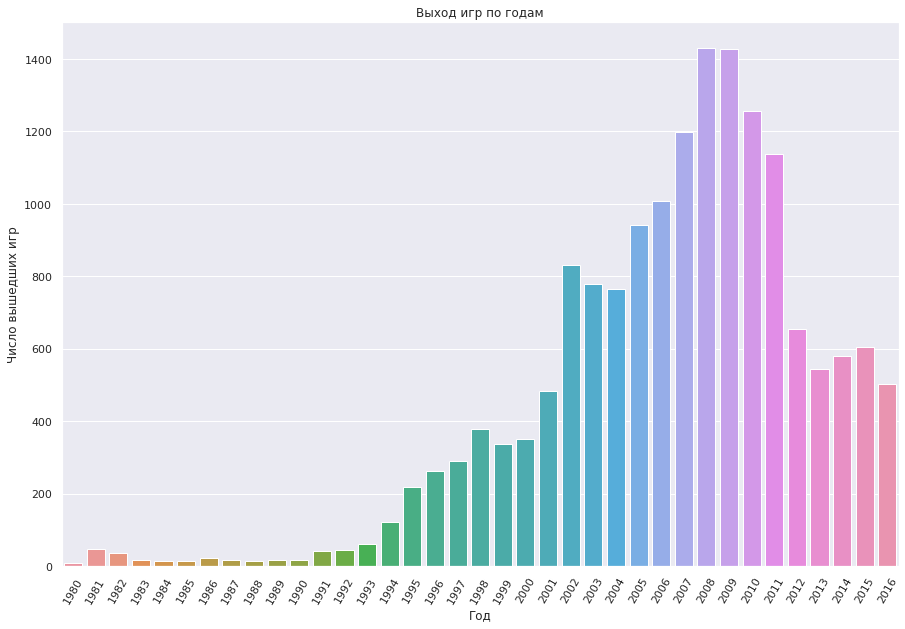

In [30]:
release_year_pivot = pd.pivot_table(df, index='year_of_release', values='genre', aggfunc='count').reset_index()
ax = sns.barplot(x=release_year_pivot['year_of_release'], y=release_year_pivot['genre'], data=release_year_pivot)
ax.set(xlabel='Год', ylabel='Число вышедших игр', title='Выход игр по годам')
ax.tick_params(axis='x', rotation=60)
plt.show()

Для нас нет смысла использовать данные за все периоды, поскольку в предыдущих периодах может быть достаточно много игр, которые выходили на неактуальную на данный момент платформу.

In [31]:
release_pivot = pd.pivot_table(df, index=['year_of_release', 'platform'], values='genre', aggfunc='count').reset_index()

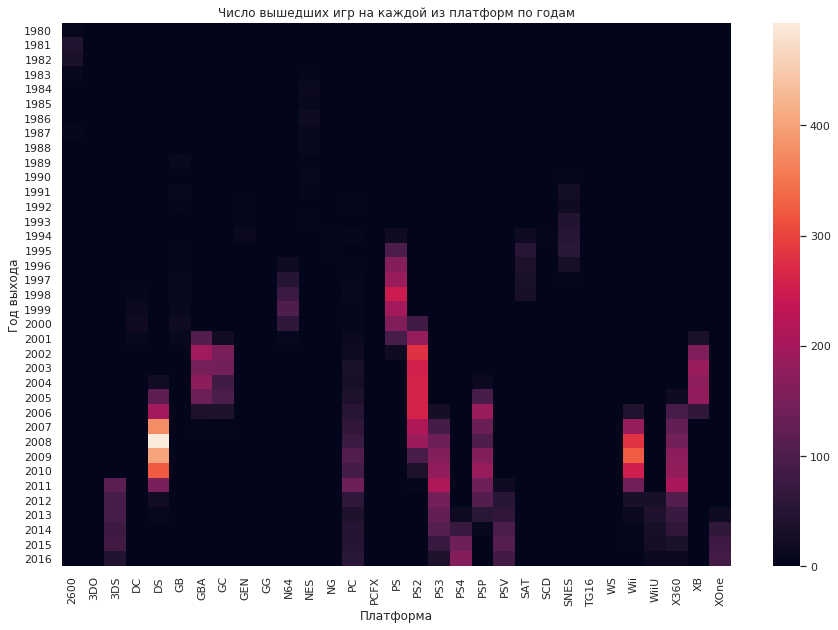

In [32]:
ax = sns.heatmap(release_pivot.pivot('year_of_release', 'platform', 'genre').fillna(0))
ax.set(xlabel='Платформа', ylabel='Год выхода', title='Число вышедших игр на каждой из платформ по годам')
plt.show()

Сравнив предыдущий график и тепловую карту попробуем использовать данные по играм, вышедшим за последние пять лет, поскольку старые платформы становятся менее популярными, а некоторые новые только набирают популярность либо находятся на пике.  
А примерно за 5-10 лет платформа появляется, достигает своего пика и затем её популярность снижается, но это применимо не ко всем платформам. К примеру, игры на PC появились давно и пропадать не собираются.

In [33]:
df = df.query('year_of_release > 2011')

Посмотрим, какие платформы лидировали по продажам за выбранный актуальный период

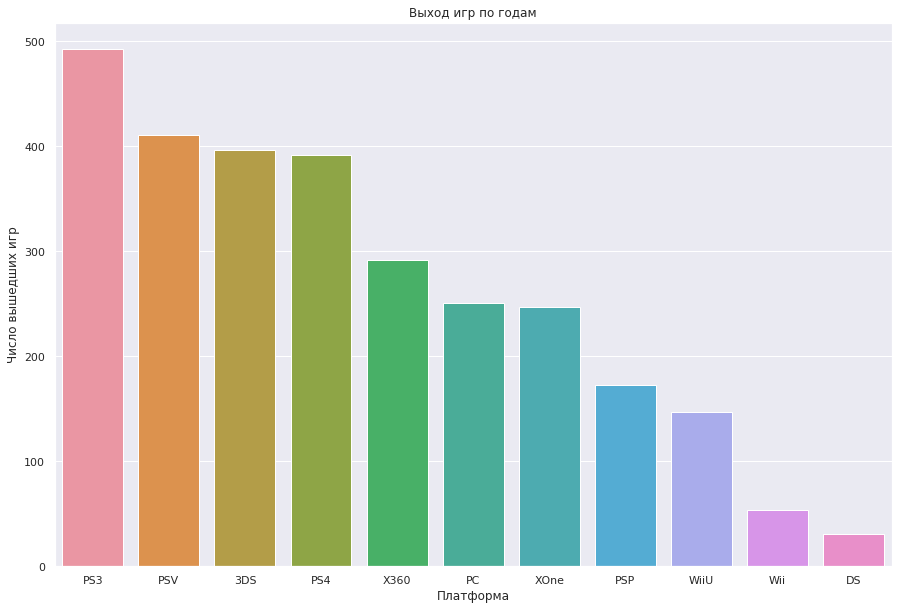

In [34]:
actual_period_pivot = pd.pivot_table(df, index='platform', values='genre', aggfunc='count').reset_index().sort_values(by='genre', ascending=False)
ax = sns.barplot(x=actual_period_pivot['platform'], y=actual_period_pivot['genre'], data=release_year_pivot)
ax.set(xlabel='Платформа', ylabel='Число вышедших игр', title='Выход игр по годам')

plt.show()

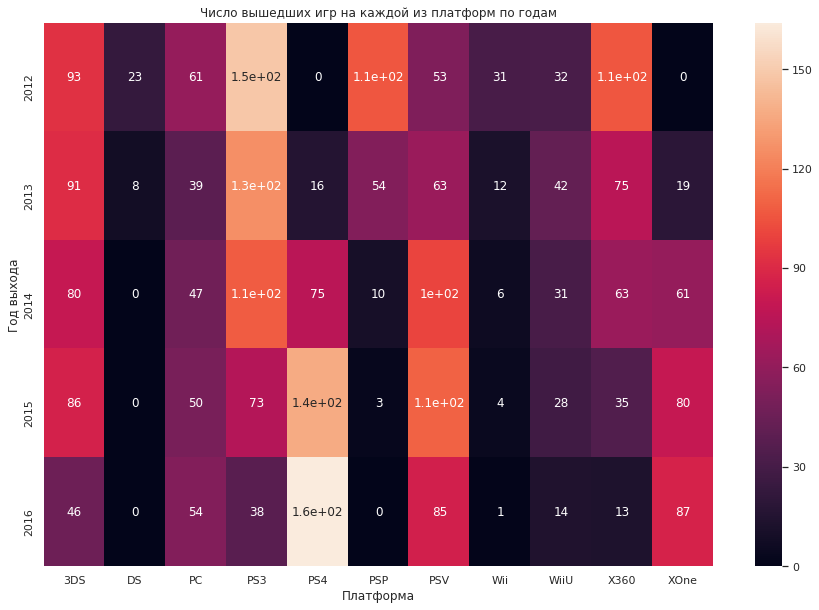

In [35]:
release_pivot = pd.pivot_table(df, index=['year_of_release', 'platform'], values='genre', aggfunc='count').reset_index()
ax = sns.heatmap(release_pivot.pivot('year_of_release', 'platform', 'genre').fillna(0), annot=True)
ax.set(xlabel='Платформа', ylabel='Год выхода', title='Число вышедших игр на каждой из платформ по годам')
plt.show()

Для дальнейшего анализа выберем более-менее "горячие" платформы, в которых число вышедших игр за актуальный период либо растет либо не так быстро падает, т.е. по построенной тепловой карте не похоже, что их популярность уже подходит к концу.  
Видим, что платформы DS, PSP, Wii, X360 и WiiU уже практически не представляют интереса для разработчиков игр.  
Между числом вышедших игр на платформы 3DS и PS3 за последние два года видим снижение, но платформы окончательно ещё не потеряли свою популярность.  
Для платформы PC наоборот наблюдается небольшой рост за последние несколько лет с 2013 года. Между 2012 и 2013 есть падение в числе вышедших игр. Возможно, это связано с длительностью разработки игр, либо обосновано какой-то другой причиной.

In [36]:
df = df.query('platform.isin(["3DS", "PC", "PS4", "PS3", "PSV", "XOne"])')

Посмотрим диаграмму размаха по продажам для каждой платформы

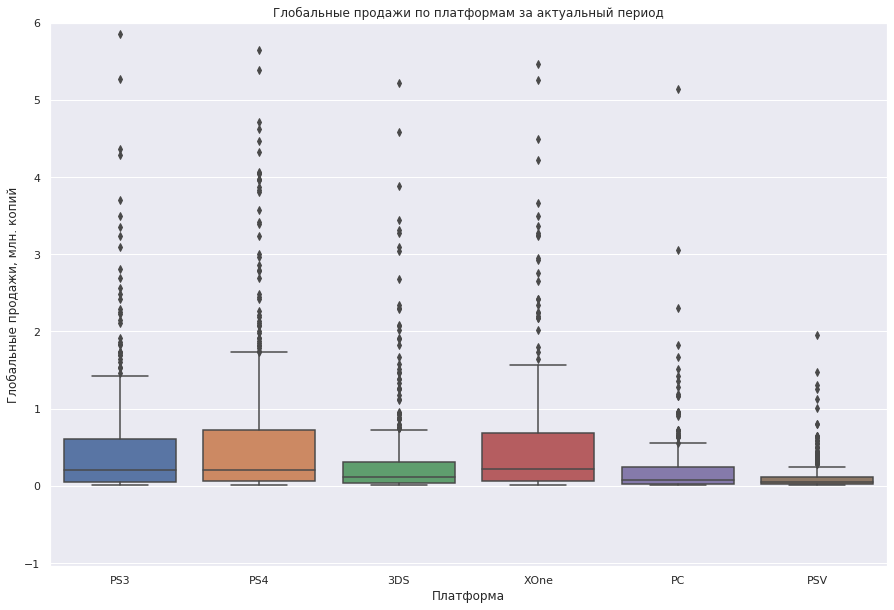

In [37]:
ax = sns.boxplot(x=df['platform'], y=df['total_sum'])
ax.set(xlabel='Платформа', ylabel='Глобальные продажи, млн. копий', title='Глобальные продажи по платформам за актуальный период')
ax.set_ylim(top=6)
plt.show()

In [38]:
sales_pivot = pd.pivot_table(df, index='platform', values='total_sum', aggfunc=['sum', 'mean', 'median']).sort_values(by=('median', 'total_sum'), ascending=False)
sales_pivot.columns = ['Суммарные продажи', 'Средние продажи', 'Медианные продажи']
sales_pivot

,Суммарные продажи,Средние продажи,Медианные продажи
platform,,,
XOne,159.3750,0.645020,0.219971
PS3,288.7500,0.585938,0.199951
PS4,314.2500,0.801270,0.199951
3DS,194.6250,0.491455,0.109985
PC,63.0000,0.250977,0.080017
PSV,49.1875,0.119629,0.049988


Лидерами по глобальным медианным и средним продажам игр являются платформы XOne и PS3

Построим диаграмму рассеяния для лидирующей платформы - XOne. Посмотрим на зависимость продаж от отзывов критиков и отзывов пользователей

In [39]:
xone_df = df.query('platform == "XOne" and user_score > 0 and critic_score > 0')

Корреляция между рейтингом пользователей и глобальными продажами: -0.094


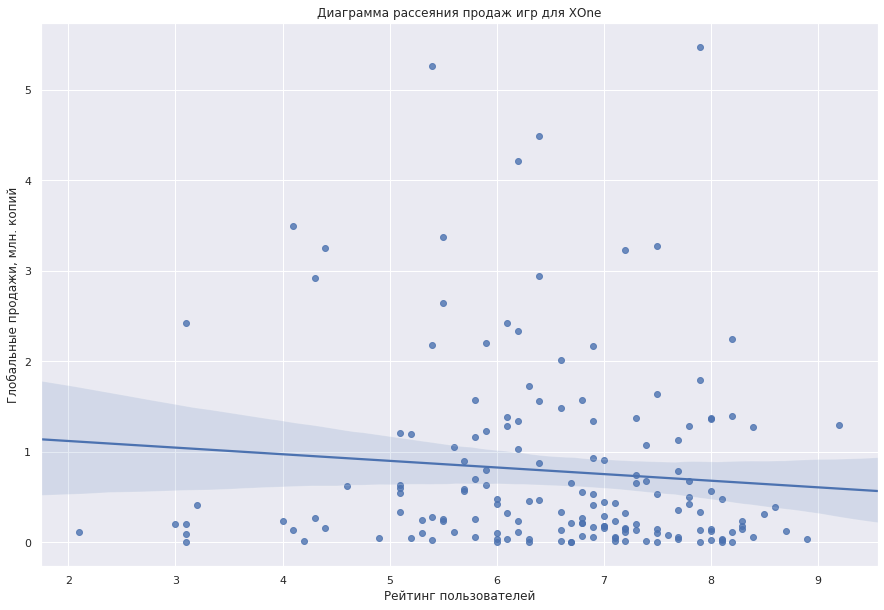

In [40]:
ax = sns.regplot(data=xone_df, x='user_score', y='total_sum')
ax.set(xlabel='Рейтинг пользователей', ylabel='Глобальные продажи, млн. копий', title='Диаграмма рассеяния продаж игр для XOne')
user_corr = xone_df[['user_score', 'total_sum']].corr()['user_score']['total_sum']
print(f'Корреляция между рейтингом пользователей и глобальными продажами: {user_corr:.2}')
plt.show()

Корреляция между рейтингом критиков и глобальными продажами: 0.41


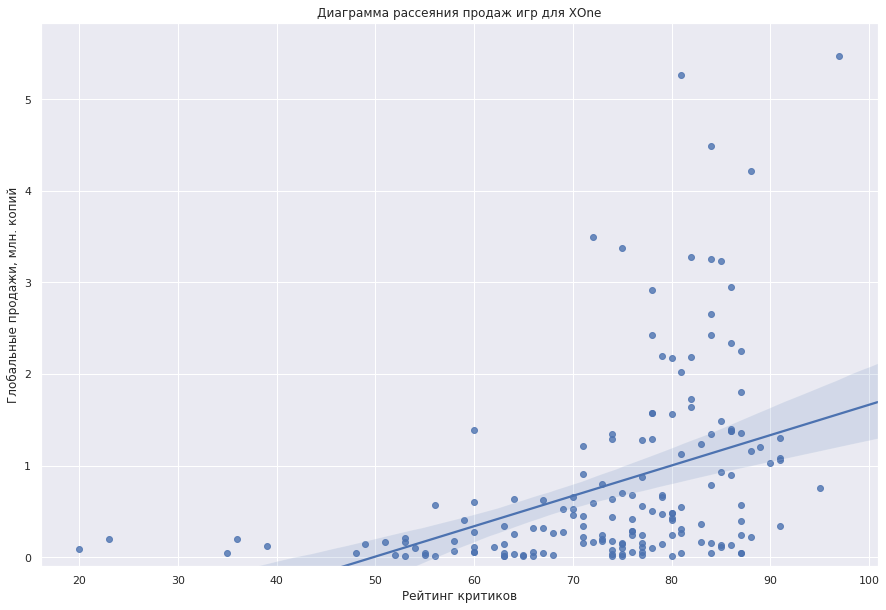

In [41]:
ax = sns.regplot(data=xone_df, x='critic_score', y='total_sum')
ax.set(xlabel='Рейтинг критиков', ylabel='Глобальные продажи, млн. копий', title='Диаграмма рассеяния продаж игр для XOne')
crit_corr = xone_df[['critic_score', 'total_sum']].corr()['critic_score']['total_sum']
print(f'Корреляция между рейтингом критиков и глобальными продажами: {crit_corr:.2}')
ax.set_ylim(bottom=-0.1)
plt.show()

Зависимость продаж от рейтинга пользователей имеет очень слабую отрицательную корреляцию.  
Зависимость продаж от рейтинга критиков имеет среднюю положительную корреляцию.  
Возможно, чем выше рейтинги критиков, тем больше игр покупают пользователи. Стоит учитывать факт, что не всегда пользователи склонны оставлять положительные или высокие оценки играм, которые им понравились, и, можно предположить, что пользователь скорее оставит низкую оценку игре, если он за неё заплатил и она ему не понравилась.
Ситуация на других платформах аналогична платформе XOne, и корреляция между отзывами критиков и продажами выше, чем между отзывами пользователей и продажами.

Посмотрим на суммарные, средние и медианные продажи по платформам

In [42]:
genres_pivot = pd.pivot_table(df, index='genre', values='total_sum', aggfunc=['count', 'sum', 'mean', 'median']).sort_values(by=('median', 'total_sum'), ascending=False)
genres_pivot.columns = ['Количество игр', 'Суммарные продажи', 'Средние продажи', 'Медианные продажи']
genres_pivot

,Количество игр,Суммарные продажи,Средние продажи,Медианные продажи
genre,,,,
Shooter,176,226.000000,1.284180,0.484863
Sports,197,137.875000,0.699707,0.229980
Platform,58,34.375000,0.592773,0.160034
Role-Playing,316,167.125000,0.528809,0.150024
Fighting,84,32.875000,0.391602,0.130005
Racing,90,37.218750,0.413330,0.119995
Simulation,67,32.906250,0.490967,0.110046
Action,767,324.500000,0.423096,0.109985
Misc,129,39.000000,0.302246,0.090027


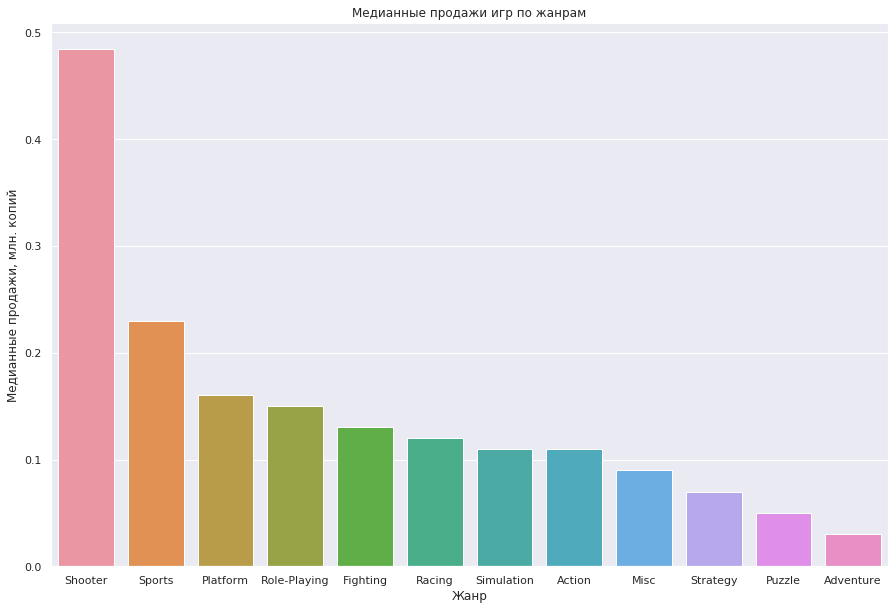

In [43]:
genres_pivot = genres_pivot.reset_index()
ax = sns.barplot(x=genres_pivot['genre'], y=genres_pivot['Медианные продажи'], data=genres_pivot.reset_index())
ax.set(xlabel='Жанр', ylabel='Медианные продажи, млн. копий', title='Медианные продажи игр по жанрам')
plt.show()

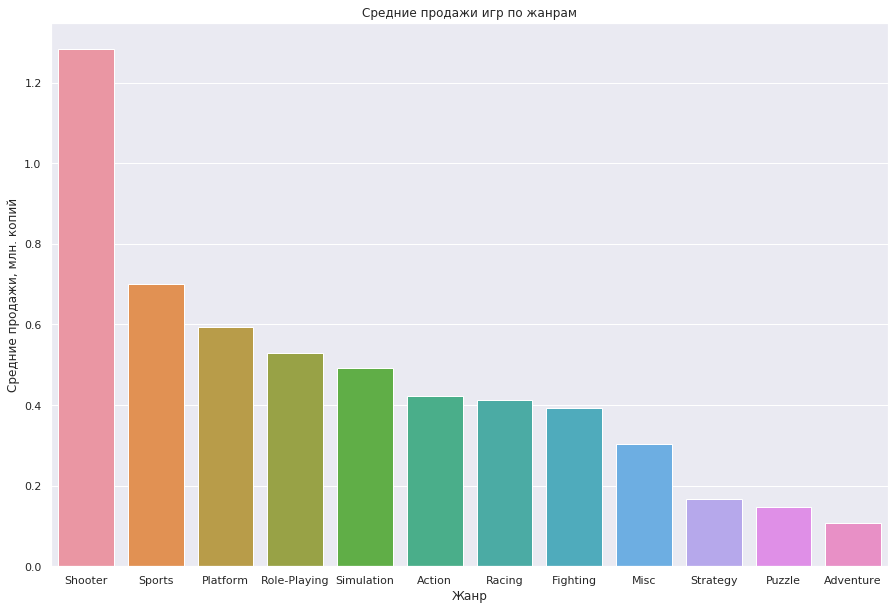

In [44]:
genres_pivot = genres_pivot.sort_values(by=('Средние продажи'), ascending=False)
ax = sns.barplot(x=genres_pivot['genre'], y=genres_pivot['Средние продажи'], data=genres_pivot)
ax.set(xlabel='Жанр', ylabel='Средние продажи, млн. копий', title='Средние продажи игр по жанрам')
plt.show()

Первые 4 лидера по медианным и средним продажам одинаковые, как и последние 3 отстающих по продажам жанров.  
На первом месте жанр Shooter, а на последнем - Adventure  
Некоторые жанры по средним продажам поменяли свои позиции относительно медианных продаж, возможно, какие-то игры были очень успешными.

При этом, по количеству выпущенных игр лидируют жанры Action, Role-Playing, Adventure. На последнем месте жанр Puzzle.

### Выводы

Выводы по результатам исследовательского анализа данных:
* Не все платформы за предыдущий период времени представляют интерес для анализа, поскольку для большинства платформ период существования составляет около 5-10 лет
* Платформа PC не относится к таким, поскольку помимо игр, у неё есть другое предназначение - работа, учеба.
* Между продажами игр и отзывами пользователей существует очень слабая отрицательная корреляция. Возможные причины - пользователи охотнее оставляют негативные оценки, а не положительные.
* Между продажами игр и отзывами критиков существует средняя положительная корреляция.
* В среднем, лучше всего продаются игры в жанре Shooter, а хуже всего - в жанре Adventure
* По количеству выпущенных игр лидирует жанр Action, На последнем месте жанр Puzzle.

## 4. Составление портретов пользователей по регионам

Посчитаем какие платформы были самыми популярными для каждого из регионов NA, EU, JP

In [45]:
na_top5 = pd.pivot_table(df, index='platform', values='na_sales', aggfunc='sum')
na_top5.sort_values(by='na_sales', ascending=False)[:5]

,na_sales
platform,
PS4,108.743294
PS3,103.379135
XOne,93.119469
3DS,55.314072
PC,19.179398


In [46]:
eu_top5 = pd.pivot_table(df, index='platform', values='eu_sales', aggfunc='sum')
eu_top5.sort_values(by='eu_sales', ascending=False)[:5]

,eu_sales
platform,
PS4,141.088257
PS3,106.862701
XOne,51.589081
3DS,42.641350
PC,38.010841


In [47]:
jp_top5 = pd.pivot_table(df, index='platform', values='jp_sales', aggfunc='sum')
jp_top5.sort_values(by='jp_sales', ascending=False)[:5]

,jp_sales
platform,
3DS,87.789742
PS3,35.289169
PSV,21.040649
PS4,15.960663
XOne,0.340050


Видим, что топ-5 платформ для Европы и Северной Америки идентичен - первое место занимает платформа PS4, а последнее - PC. А вот на японском рынке ситуация иная - лидирует платформа 3DS, на последнем месте платформа XOne.

Посмотрим на самые популярные жанры в каждом из регионов

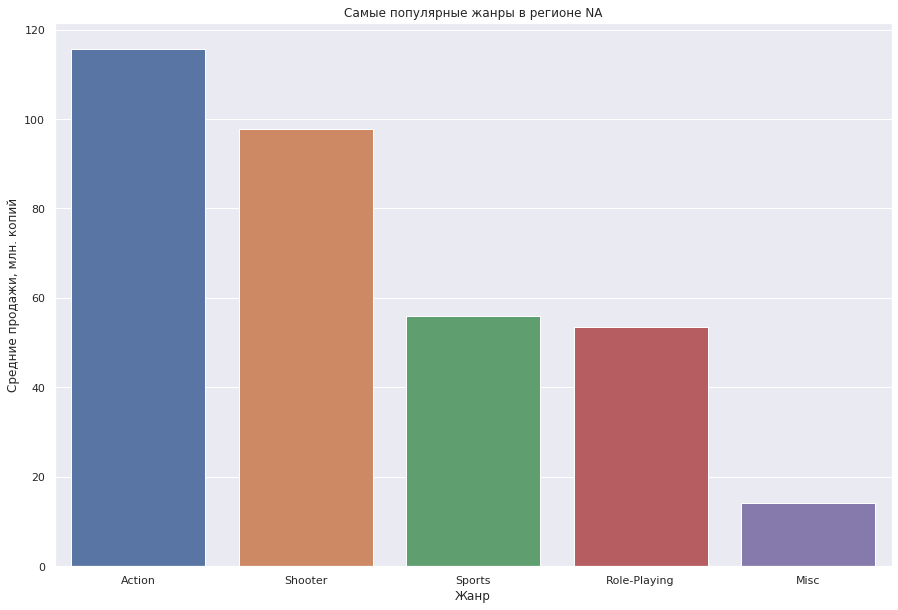

In [48]:
na_top5_g = pd.pivot_table(df, index='genre', values='na_sales', aggfunc='sum')
na_top5_g = na_top5_g.sort_values(by='na_sales', ascending=False)[:5]
ax = sns.barplot(data=na_top5_g, x=na_top5_g.index, y='na_sales')
ax.set(xlabel='Жанр', ylabel='Средние продажи, млн. копий', title='Самые популярные жанры в регионе NA')
plt.show()

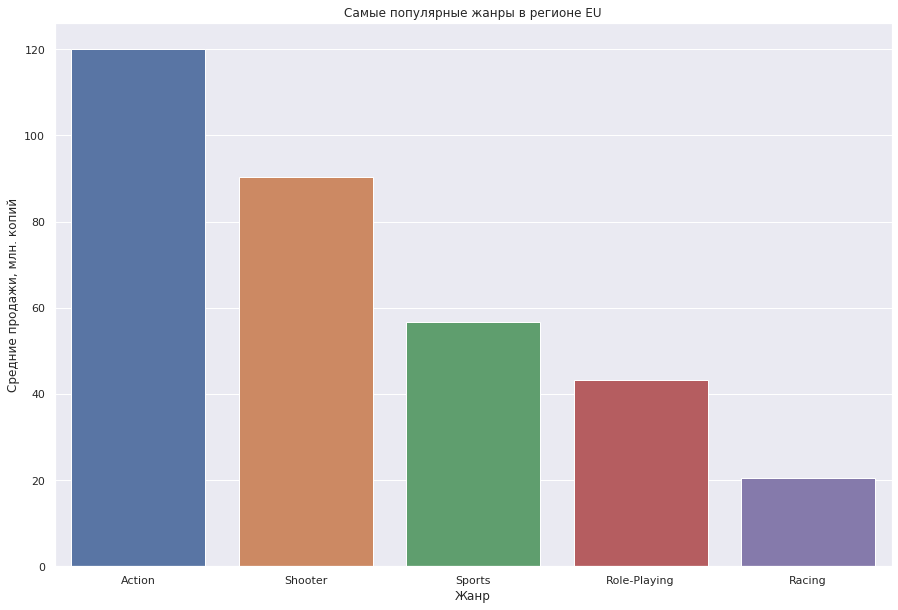

In [49]:
eu_top5_g = pd.pivot_table(df, index='genre', values='eu_sales', aggfunc='sum')
eu_top5_g = eu_top5_g.sort_values(by='eu_sales', ascending=False)[:5]
ax = sns.barplot(data=eu_top5_g, x=eu_top5_g.index, y='eu_sales')
ax.set(xlabel='Жанр', ylabel='Средние продажи, млн. копий', title='Самые популярные жанры в регионе EU')
plt.show()

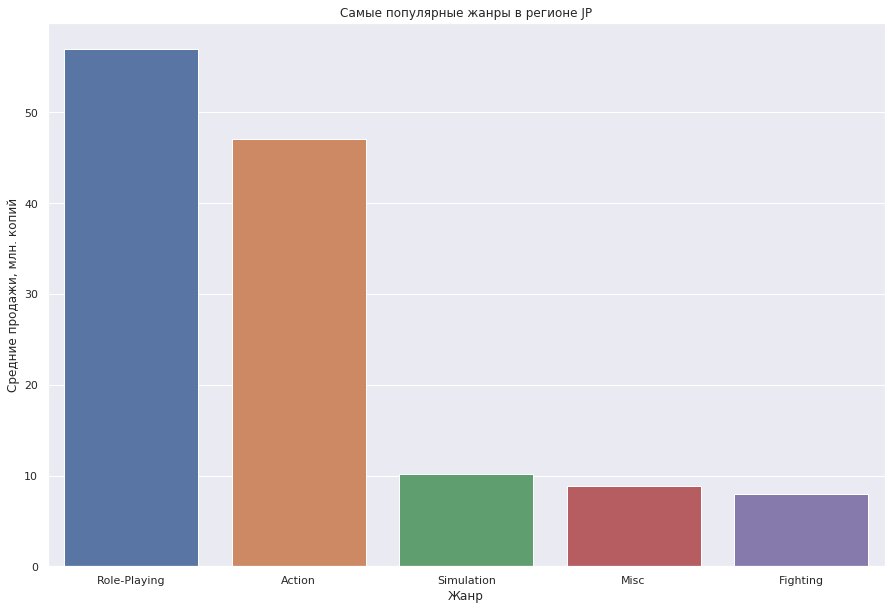

In [50]:
jp_top5_g = pd.pivot_table(df, index='genre', values='jp_sales', aggfunc='sum')
jp_top5_g = jp_top5_g.sort_values(by='jp_sales', ascending=False)[:5]
ax = sns.barplot(data=jp_top5_g, x=jp_top5_g .index, y='jp_sales')
ax.set(xlabel='Жанр', ylabel='Средние продажи, млн. копий', title='Самые популярные жанры в регионе JP')
plt.show()

В регионах EU и NA первые 4 места топ-5 занимают одни и те же жанры. В регионе JP отличи начинаются уже со второй позиции

Посмотрим на влияние рейтинга ESRB на продажи игр в каждом из регионов

Сначала сумму продаж

In [51]:
rating_df = df.query('rating != 0')

In [52]:
pd.pivot_table(rating_df, index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum').T

rating,E,E10+,M,T
eu_sales,84.508293,30.640396,155.073212,44.190781
jp_sales,20.091499,5.100357,19.829758,25.009514
na_sales,71.279175,35.991234,155.239540,49.730545


Средние продажи

In [53]:
pd.pivot_table(rating_df, index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='mean').T

rating,E,E10+,M,T
eu_sales,0.309554,0.150938,0.402788,0.127719
jp_sales,0.073595,0.025125,0.051506,0.072282
na_sales,0.261096,0.177297,0.403220,0.143730


И медианные продажи

In [54]:
pd.pivot_table(rating_df, index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='median').T

rating,E,E10+,M,T
eu_sales,0.059998,0.090027,0.140015,0.040009
jp_sales,0.000000,0.000000,0.000000,0.020004
na_sales,0.049988,0.109985,0.140015,0.040009


Видим, что вне зависимости от рейтинга, нет большой разницы между суммой, медианой и средними значениями продаж для регионов Северная Америка и Европа. В регионе Япония лучшие продажи у игр с рейтингом T. По остальным же трем рейтингам не менее половины игр не продавались совсем.

### Выводы

Общие выводы по регионам:
* Регионы NA и EU в целом очень схожи между собой, по предпочитаемой платформе, жанру игр, а так же по продажам игр в зависимости рейтинга.
* Регион JP очень сильно отличается от двух других по всем параметрам - в топ 5 платформ нет PC, не менее половины игр с рейтингом E, E10+, M не имеют продаж в этом регионе

## 5. Проверка гипотез

Посмотрим на средние пользовательские рейтинги платформ XOne и PC.
Проверим гипотезу о том, что средние пользовательские рейтинги платформ XOne и PC одинаковые.  
Для проверки гипотез выберем стандартный критический уровень статистической значимости равный 0.05. Поскольку выборки независимые, используем тест для независимых выборок.

**$H_0$**: Cредние пользовательские рейтинги платформ XOne и PC не различаются

**$H_1$**: Cредние пользовательские рейтинги платформ XOne и PC различается

In [55]:
df = df.query('user_score > 0')
alpha = 0.05
results = st.ttest_ind(df[df['platform'] == 'XOne']['user_score'], df[df['platform'] == 'PC']['user_score'], equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.5786590845638211
Не получилось отвергнуть нулевую гипотезу


In [56]:
mean_xone = df[df['platform'] == 'XOne']['user_score'].mean()
mean_pc = df[df['platform'] == 'PC']['user_score'].mean()
print(f'Средний пользовательский рейтинг игр для платформы XOne: {mean_xone}')
print(f'Средний пользовательский рейтинг игр для платформы PC: {mean_pc}')

Средний пользовательский рейтинг игр для платформы XOne: 6.5234375
Средний пользовательский рейтинг игр для платформы PC: 6.44140625


Нам не удалось отвергнуть нулевую гипотезу. Видим, что средние значения рейтинга для платформ XOne и PC различаются не очень сильно и у нас нет оснований для принятия альтернативной гипотезы.

Посмотрим на средние пользовательские рейтинги игр в жанрах Action и Sports. Проверим гипотезу о том, что средние пользовательские рейтинги игр в жанрах Action и Sports различаются.
Уровень статистической значимости и тип используемого теста оставим без изменений.

**$H_0$**: Cредние пользовательские рейтинги жанров Action и Sports не различаются

**$H_1$**: Cредние пользовательские рейтинги жанров Action и Sports различаются

In [57]:
alpha = 0.05
results = st.ttest_ind(df[df['genre'] == 'Action']['user_score'], df[df['genre'] == 'Sports']['user_score'], equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 4.40799318278595e-15
Отвергаем нулевую гипотезу


In [58]:
mean_action = df[df['genre'] == 'Action']['user_score'].mean()
mean_sports = df[df['genre'] == 'Sports']['user_score'].mean()
print(f'Средний пользовательский рейтинг игр для жанра Action: {mean_action}')
print(f'Средний пользовательский рейтинг игр для жанра Sports: {mean_sports}')

Средний пользовательский рейтинг игр для жанра Action: 6.8828125
Средний пользовательский рейтинг игр для жанра Sports: 5.53515625


Мы отвергли нулевую гипотезу. Видим, что средние значения рейтинга для игр в жанрах Action и Sports различаются более чем на 1, поэтому у нас есть основания для принятия альтернативной гипотезы.

## 6. Общий вывод

Выводы по обработке данных:
* Обнаружены неверные типы данных, требующие выделение большего объема памяти
* Возможно, при формировании датасета были проблемы с парсингом, так как у части игр не указан год выпуска, либо он указан в названии
* В трех колонках пропущенно более 40% данных, нужно выяснить причину и обсудить решение данной проблемы.
* Символы в названиях колонок имеют разный регистр, этого следует избегать при формировании датасета.
 
 
Выводы по анализу данных:
* Для большинства платформ, кроме платформы PC, период существования составляет около 5-10 лет
* Между продажами игр и отзывами пользователей существует очень слабая отрицательная корреляция. Возможные причины - пользователи охотнее оставляют негативные оценки, а не положительные.
* Между продажами игр и отзывами критиков существует средняя положительная корреляция. Вероятно, после прочтения отзывов критиков, пользователи принимают решение о приобретении той или иной игры, но это не единственный критерий.
* В среднем, лучше всего продаются игры в жанре Shooter, а хуже всего - в жанре Adventure
* По количеству выпущенных игр лидирует жанр Action, На последнем месте жанр Puzzle.
* Регионы NA и EU очень схожи между собой по предпочитаемой платформе, жанру игр, а так же по продажам игр в зависимости рейтинга.
* Регион JP очень сильно отличается от EU и NA по всем параметрам - в топ 5 платформ в регионе JP нет PC, не менее половины игр с рейтингом E, E10+, M не имеют продаж в этом регионе.
* Мы приняли нулевую гипотезу о том, что средние значения рейтинга для платформ XOne и PC не различаются и сравнили средние значения рейтинга для этих платформ.
* Мы приняли альтернативную гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports различаются и сравнили средние значения рейтинга для игр в этих жанрах.

Итоги:
* При планировании кампании на следующий год НЕ стоит учитывать отзывы пользователей как один из критериев
* При планировании кампании на следующий год можно учитывать отзывы критиков как один из критериев
* Для различных регионов стоит учитывать популярные платформы
* Для различных регионов стоит учитывать популярные жанры игр
* Для различных регионов, в особенности для JP, стоит учитывать рейтинг продаваемых игр